In [1]:
ATTACK_EPS = 0.5
ATTACK_STEPSIZE = 0.1
ATTACK_STEPS = 10
NUM_WORKERS = 8
BATCH_SIZE = 128

## Set up dataset

In [2]:
import torch as ch
from robustness.datasets import FashionMnist
ds = FashionMnist('/tmp/FashionMNIST')

## Instantiate model

In [3]:
from robustness.model_utils import make_and_restore_model
model, _ = make_and_restore_model(arch='resnet18', dataset=ds,
              resume_path= '/home/ashraf.haddad/mlpr/Fashion_Store_ADV/checkpoint.pt.best') #'/tmp/35daedae-1b39-4941-ad08-8bd6459c1bd8/checkpoint.pt.best')
model.eval()
pass

=> loading checkpoint '/home/ashraf.haddad/mlpr/Fashion_Store_ADV/checkpoint.pt.best'
=> loaded checkpoint '/home/ashraf.haddad/mlpr/Fashion_Store_ADV/checkpoint.pt.best' (epoch 36)


## Set up loaders

In [4]:
# device will be 'cuda' if a GPU is available
device = ch.device('cuda' if ch.cuda.is_available() else 'cpu')

#only load the validation set
_, test_loader = ds.make_loaders(workers=NUM_WORKERS, batch_size=BATCH_SIZE)
_, (im, label) = next(enumerate(test_loader))  
im,label = im.to(device),label.to(device)


print(im.device, type(im))
print(label.device,type(label))
print(next(model.parameters()).device)


==> Preparing dataset fashionmnist..


/home/ashraf.haddad/.conda/envs/rob/lib/python3.9/site-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


cuda:0 <class 'torch.Tensor'>
cuda:0 <class 'torch.Tensor'>
cuda:0


## Generating untargeted adversarial examples

In [5]:
kwargs = {
    'constraint':'2', # use L2-PGD
    'eps': ATTACK_EPS, # L2 radius around original image
    'step_size': ATTACK_STEPSIZE,
    'iterations': ATTACK_STEPS,
    'do_tqdm': True,
}
label.size()

torch.Size([128])

In [6]:
#the model can generate adv by applying max l-infinity loss
_, im_adv = model(im, label, make_adv=True, **kwargs)

Current loss: 0.356586754322052: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


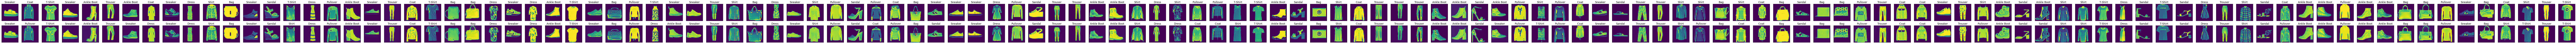

In [7]:
from robustness.tools.vis_tools import show_image_row
from robustness.tools.label_maps import CLASS_DICT

# Get predicted labels for adversarial examples using 
pred, _ = model(im_adv)
label_pred = ch.argmax(pred, dim=1)

# Visualize test set images, along with corresponding adversarial examples
show_image_row([im.cpu(), im_adv.cpu()],
         tlist=[[CLASS_DICT['FashionMnist'][int(t)] for t in l] for l in [label, label_pred]],
         fontsize=18,
         filename='./adversarial_example_FASHION.png')

In [28]:
CLASS_DICT['FashionMnist'][0]



'T-Shirt'

## Targeted adversarial examples